In [3]:
# ---- Parameters ----
SCREEN = "20250216_AWALS37_Full_screen_n96"
ANALYSIS = "multiclass"
MARKER = "all"
ANTIBODY = ["FUS/EEA1"]

In [4]:
import json
import pickle
import pandas as pd
from pathlib import Path
from maps.screens import ImageScreenMultiAntibody

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/pipelines/params")
with open(pdir / f"{ANALYSIS}.json", "r") as f:
    params = json.load(f)

params["screen"] = SCREEN
params["antibodies"] = [
    a.replace("/atubulin", "") for a in params["antibodies"]
]

# initialize key mapping cell lines to mutations
screen = ImageScreenMultiAntibody(params)
plate_dirs = screen.loader._get_plate_dirs()
metadata = screen.loader.load_metadata(plate_dirs[0])
cellline_to_mutation = dict(zip(metadata["CellLines"], metadata["Mutations"]))

# load in analysis results
output_dir = Path(params.get("result_dir")) / params.get("screen")
ab_str = "_".join(ANTIBODY).replace("/", "-")
with open(output_dir / f"{ANALYSIS}-{ab_str}-{MARKER}.pkl", "rb") as f:
    results = pickle.load(f)

map_analysis = results["analysis"]

# load in cell line metdata
mdir = Path("/awlab/projects/2024_ALS/data/cell_lines")
metadata = pd.read_csv(mdir / "FibroblastCellLine_cleaned.csv")
cellline_to_age = metadata.set_index("CellLines")["AgeOfBiopsy"].to_dict()

# i-MAP score visualizations

Predictions are stored under the `fitted` attribute of the `MAPS` class. The fitted attribute includes data on the fitted model, cell lines used to train that model, and predicted values. If the `fitter` used to train models iterates over genetic backgrounds, the `fitted` attribute will be keyed by genetic background (with one set of models, predictions, etc. per genetic background). The example below shows the first instance.

In [5]:
predictions = map_analysis.fitted["predicted"].to_pandas()
predictions["Mutations"] = predictions["CellLines"].map(cellline_to_mutation)

predictions = (
    predictions.groupby(["CellLines", "Mutations"])
    .mean()
    .reset_index()
)

predictions.head()

,CellLines,Mutations,Class_0,Class_1,Class_2,Class_3,True
0,11,WT,0.228262,0.155148,0.303874,0.312715,0.0
1,ALS1,WT,0.233466,0.214130,0.300928,0.251476,0.0
2,ALS15,WT,0.394443,0.170039,0.227665,0.207853,0.0
3,ALS18,WT,0.315611,0.227424,0.171429,0.285536,0.0
4,ALS20,WT,0.286071,0.226625,0.156536,0.330768,0.0


## iMAPS heatmaps
The iMAPS heatmaps show model genetics on the y-axis and cell lines on the x-axis. In the case of multiclass classification, we view model genetics as the corresponding class probability. In contrast, binary classification models will train separate models for each genetic background.

In [47]:
# Reformat predictions data frame to long format for heatmap visualization
predictions = predictions.melt(
    id_vars=["CellLines", "Mutations", "True"], 
    var_name="ModelGenetics", 
    value_name="Predictions"
)

map_response = params["analysis"]["MAP"]["data_loader"]["response_map"]
map_response = {v:k for k, v in map_response["Mutations"].items()}
predictions.head()
predictions["ModelGenetics"] = (
    predictions["ModelGenetics"]
    .str.replace("Class_", "", regex=False)
    .astype(int)
    .map(map_response)
)

predictions = predictions.rename(columns={"Predictions": "Class_1"})
predictions = predictions[predictions["ModelGenetics"] != "WT"]
predictions.head()


,CellLines,Mutations,True,ModelGenetics,Class_1
81,11,WT,0.0,FUS,0.155148
82,ALS1,WT,0.0,FUS,0.214130
83,ALS15,WT,0.0,FUS,0.170039
84,ALS18,WT,0.0,FUS,0.227424
85,ALS20,WT,0.0,FUS,0.226625


/home/kkumbier/maps/maps/figures.py:135: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby('ModelGenetics', group_keys=False).apply(_scale_row)
/home/kkumbier/maps/maps/figures.py:147: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = plot_df.pivot_table(index='ModelGenetics', columns='CellLines', values=fill_col, aggfunc='mean')


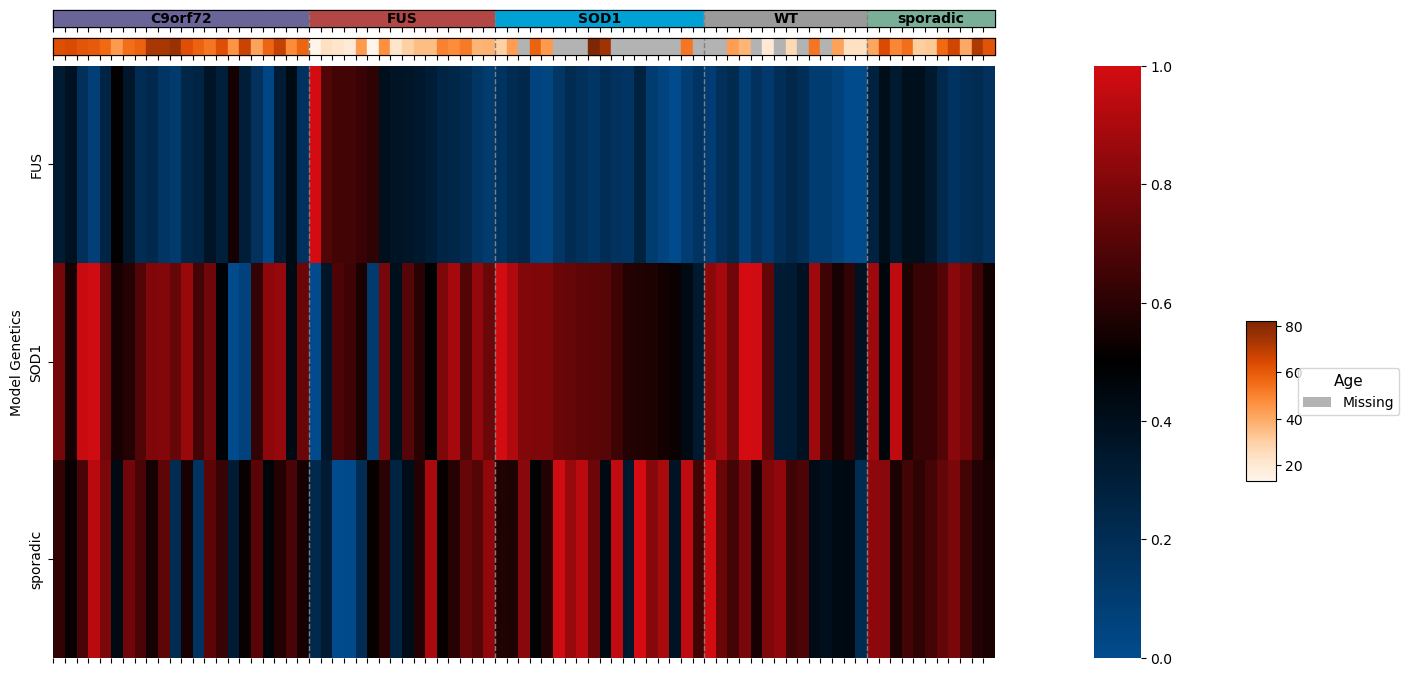

In [49]:
from maps.figures import plot_imap_heatmap
fig = plot_imap_heatmap(
    predictions, 
    cellline_to_mutation=cellline_to_mutation, 
    cellline_to_age=cellline_to_age,
    figsize= (15, 8)
)

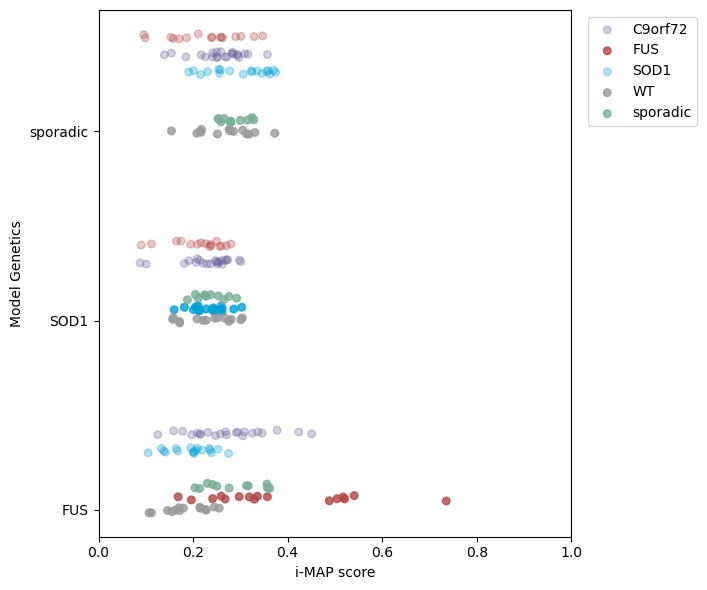

In [51]:
from maps.figures import plot_imap_scatter

fig = plot_imap_scatter(
    predictions,
    cellline_to_mutation=cellline_to_mutation,
    figsize=(8, 6)
)
